The tutorials use PyTorch. You will need to load the following dependencies.

In [ ]:
# This specific version of torchvision is needed to download the mnist set
!pip3 install torch torchvision

In [1]:
import io
import json
import os
import random
import re
import urllib.request

import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import skimage.transform
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from IPython import display
from torchvision import datasets, transforms

# Tutorial 3: Residual Neural Network (ResNet)

The code below helps visualize PyTorch tensors as images, loads the MNIST training set, and provides training and test functions just like in the previous two tutorials.

In [2]:
%matplotlib inline


def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.grid(False)
    plt.gca().axis("off")


def display_thumb(img):
    display.display(transforms.Resize(128)(img))

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load the training and test dataset.
mnist_train = datasets.MNIST(
    "/tmp/mnist", train=True, download=True, transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    "/tmp/mnist", train=False, download=True, transform=transforms.ToTensor()
)

# Size of the batches the data loader will produce.
batch_size = 64

# This creates the dataloaders.
train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    mnist_test, batch_size=batch_size, shuffle=False
)

In [29]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model."""

    # Make sure model is in training mode.
    model.train()

    # Move model to the device.
    model.to(device)

    # Exponential moving average of the loss.
    ema_loss = None

    # Loop over epochs.
    for epoch in range(num_epochs):

        # Loop over data.
        for batch_idx, (data, target) in enumerate(data_loader):

            # Forward pass.
            output = model(data.to(device))
            loss = criterion(output.to(device), target.to(device))

            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # NOTE: It is important to call .item() on the loss before summing.
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss += (loss.item() - ema_loss) * 0.01

        # Print out progress the end of epoch.
        print(
            "Train Epoch: {} \tLoss: {:.6f}".format(epoch, ema_loss),
        )


def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""

    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for data, target in data_loader:

            # Forward pass.
            output = model(data.to(device))

            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)

            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100.0 * correct / len(data_loader.dataset)
    print(f"Accuracy: {correct}/{len(data_loader.dataset)} ({percent:.0f}%)")
    return percent

# Tutorial 5. Residual Network

We are going train a deep neural network using residual connections [2].

The network below has a list of `conv_blocks`. Each convolutional block is convolution layer followed by a ReLU with optional pooling.

[2] He, Kaiming, et al. "Identity mappings in deep residual networks." European conference on computer vision. Springer, Cham, 2016.

**Task**. Implement residual connections within `apply_conv_block`. Residual connection sum the output of a convolutional block with its input. Note that if the output and input have different sizes, you should skip the residual connection for that layer.

In [25]:
def my_relu(x):
    return torch.maximum(x, torch.zeros_like(x))

In [39]:
class DeepConvolutionalNetwork(nn.Module):
    """Convolutional network that can go arbitrary deep."""

    def __init__(self, num_repeated_layers=1, use_residuals=False):
        super().__init__()
        num_channels = 8
        self.use_residuals = use_residuals

        conv_blocks = []
        # 1x28x28 -> 8x12x12.
        conv_blocks.append(
            nn.Sequential(
                nn.Conv2d(1, num_channels, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(inplace=True),
            )
        )
        for _ in range(num_repeated_layers):
            conv_blocks.append(
                nn.Sequential(
                    nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                )
            )
        # 8x12x12 -> 8x4x4.
        conv_blocks.append(
            nn.Sequential(
                nn.Conv2d(num_channels, num_channels, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(inplace=True),
            )
        )
        # It's important to wrap layers into ModuleList so the PyTorch knows that
        # the self.conv_blocks has parameters to optimize.
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.linear = nn.Linear(num_channels * 4**2, 10)

    def apply_conv_block(self, conv_block, x):
        output = conv_block(x)
        if not self.use_residuals:
            return output
        else:
            ###########################################################################
            # Implement the residual connection below.                                #
            ###########################################################################
            #Implement the residual connection.
            if output.shape == x.shape:
                output = output.clone() + x
            return output

    def forward(self, x):
        for block in self.conv_blocks:
            x = self.apply_conv_block(block, x)
        x = self.linear(x.view(x.size(0), -1))
        return x

Let's look at the modules in our deep network.

In [40]:
import torch
torch.autograd.set_detect_anomaly(True)


In [41]:
# Print the structure of a (residual) network with 3 convolutional layers.
DeepConvolutionalNetwork(3)

DeepConvolutionalNetwork(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace=True)
    )
    (1-3): 3 x Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace=True)
    )
  )
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

Now we are going to train the model with increasing number of layers with and without residual connections. What do you observe?

In [42]:
for num_layer in 1, 5:
    for use_residual in [False, True]:
        print(
            f"Training a neural network with {num_layer} layers and use_residual={use_residual}"
        )
        conv_model = DeepConvolutionalNetwork(num_layer, use_residuals=use_residual)
        optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-1)
        train(conv_model, nn.CrossEntropyLoss(), train_loader, optimizer, num_epochs=1)
        accuracy = test(conv_model, test_loader)
        if use_residual:
            assert (
                accuracy > 90
            ), "Accuracy is very low. Check the implementation of your residual network."
print("Done.")

Training a neural network with 1 layers and use_residual=False
Train Epoch: 0 	Loss: 0.128950
Accuracy: 9676/10000 (97%)
Training a neural network with 1 layers and use_residual=True
Train Epoch: 0 	Loss: 0.121140
Accuracy: 9650/10000 (96%)
Training a neural network with 5 layers and use_residual=False
Train Epoch: 0 	Loss: 2.300858
Accuracy: 1135/10000 (11%)
Training a neural network with 5 layers and use_residual=True
Train Epoch: 0 	Loss: 0.107104
Accuracy: 9705/10000 (97%)
Done.


## Imagenet

Imagenet is the most famous dataset for image classification that is still in use. Real ImageNet dataset is very big (~150Gb). So we will use a smaller version that contains only two classes: bees and ants.

First, download the required files and construct the dataset.

In [43]:
! rm -rf /tmp/imagenet/unpacked
! mkdir -p /tmp/imagenet/unpacked
! [[ -f /tmp/imagenet/hymenoptera_data.zip ]] || curl https://download.pytorch.org/tutorial/hymenoptera_data.zip > /tmp/imagenet/hymenoptera_data.zip
! cd /tmp/imagenet/unpacked && unzip ../hymenoptera_data.zip > /dev/null
imagenet_dataset = datasets.ImageFolder("/tmp/imagenet/unpacked/hymenoptera_data/val")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.0M  100 45.0M    0     0   930k      0  0:00:49  0:00:49 --:--:-- 1298k2M    0     0   836k      0  0:00:55  0:00:13  0:00:42 1215k    0   785k      0  0:00:58  0:00:16  0:00:42  821k    0     0   863k      0  0:00:53  0:00:40  0:00:13  795k


Explore the images within the dataset. Unlike MNIST or CIFAR the dataset has relatively high-resolution images that can vary in size.

ImageNet classes: ants bees
Label of image: 0 (ants). Original size: (500, 333)


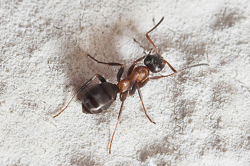

Label of image: 1 (bees). Original size: (800, 533)


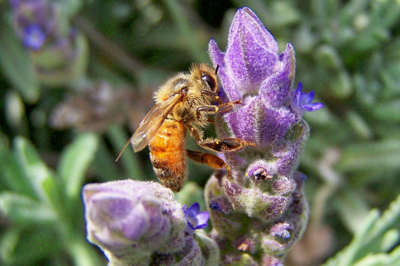

Label of image: 0 (ants). Original size: (500, 333)


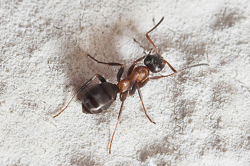

In [44]:
print("ImageNet classes:", *imagenet_dataset.classes)

# Show a random image and the corresponding target.
for i in range(3):
    img, target = random.choice(imagenet_dataset)
    print(
        "Label of image: %d (%s). Original size: %s"
        % (target, imagenet_dataset.classes[target], img.size)
    )

    # Reduce image size by half to fit the images on the page :)
    display.display(img.resize((img.size[0] // 2, img.size[1] // 2)))

A common technique to handle this is to take some segment of the image and resize it to have an image of fixed square size.

For training the segment selection is usually randomized.
For evaluation a "center" crop is used.

Actual image:


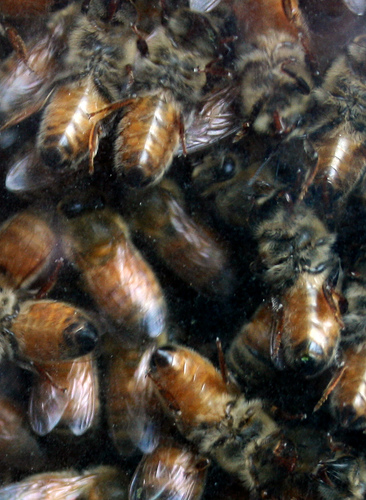

Input to the net for training


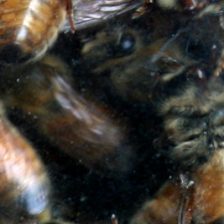

Input to the net for evaluation


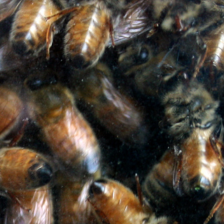

In [45]:
img, _ = random.choice(imagenet_dataset)
print("Actual image:")
display.display(img)
print("Input to the net for training")
display.display(transforms.RandomResizedCrop(224)(img))
print("Input to the net for evaluation")
display.display(transforms.CenterCrop(224)(transforms.Resize(256)(img)))

If a pre-trained model is used, it's important to match the transformation.

In [46]:
# This is the default transform used in ImageNet models.
inference_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# For visualization purposes we'll create a separate transform that operates in image space.
inference_transform_show = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ]
)

# Reload out dataset with this transform.
transformed_imagenet_dataset = datasets.ImageFolder(
    "/tmp/imagenet/unpacked/hymenoptera_data/val",
    transform=inference_transform,
)

transformed_imagenet_loader = torch.utils.data.DataLoader(
    transformed_imagenet_dataset, batch_size=16, shuffle=False
)

# Load a pretrained model.
imagenet_resnet = torchvision.models.resnet18(pretrained=True)

# The loaded model is trained to classify image across 1000 classes. We have only two classes so have to take the two correpsonding lines from the softmax.
ANT_CLASS_ID = 310
BEE_CLASS_ID = 309
imagenet_resnet.fc.weight.data = imagenet_resnet.fc.weight.data[
    [ANT_CLASS_ID, BEE_CLASS_ID]
]
imagenet_resnet.fc.bias.data = imagenet_resnet.fc.bias.data[
    [ANT_CLASS_ID, BEE_CLASS_ID]
]

# If GPU available, transfer model there
if device == "cuda":
    imagenet_resnet = imagenet_resnet.cuda()

# Check the model accuracy.
test(imagenet_resnet, transformed_imagenet_loader)

/Users/uriel/Anaconda/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/uriel/Anaconda/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/uriel/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████| 44.7M/44.7M [00:53<00:00, 878kB/s]


Accuracy: 147/153 (96%)


96.07843137254902

The model quality is pretty high, but there are a few mistakes. Explore misclassified images below. Why do you think the network made a mistake?


Img id=6. Excpected class ants, but predicted class bees.


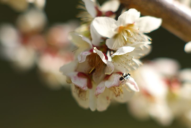

Img id=41. Excpected class ants, but predicted class bees.


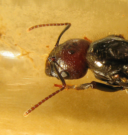

Img id=81. Excpected class bees, but predicted class ants.


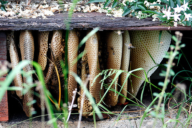

Img id=114. Excpected class bees, but predicted class ants.


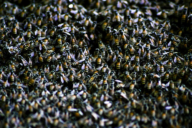

Img id=144. Excpected class bees, but predicted class ants.


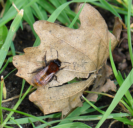

Img id=150. Excpected class bees, but predicted class ants.


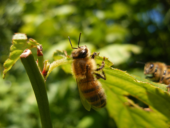

In [47]:
imagenet_resnet.eval()  # make sure the model is in evaluation mode

for i in range(len(transformed_imagenet_dataset)):
    img, _ = imagenet_dataset[i]
    tensor, target = transformed_imagenet_dataset[i]

    if device == "cuda":
        tensor = tensor.cuda()

    _, prediction = imagenet_resnet(tensor.unsqueeze(0)).squeeze(0).cpu().max(-1)
    if prediction != target:
        print(
            "Img id=%d. Excpected class %s, but predicted class %s."
            % (
                i,
                imagenet_dataset.classes[target],
                imagenet_dataset.classes[prediction],
            )
        )
        display_thumb(img)

I think the network made a mistake because of the random crop or also the background where the object to detect is, which is not clear

**Task** As you saw, the random crop does not always catch the object. Let's understand what it does for a image. For a random image from `imagenet_dataset` sample a few random crops and find the most _bee-like_ and the most _ant-like_ ones. How do they look like?

Most ant-like


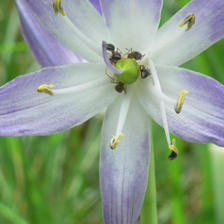

Most bee-like


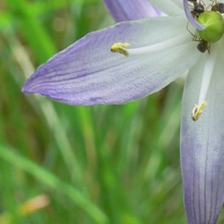

In [62]:
imagenet_resnet.eval()  # make sure the model is in evaluation mode

random_id = 40
img, _ = imagenet_dataset[random_id]

random_crops = [transforms.RandomResizedCrop(224)(img) for _ in range(10)]


def beeness(image):

    # Convert image to tensor and apply default for the dataset mean-variance normalization.
    image = transforms.ToTensor()(image)
    image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
    image = image.unsqueeze(0)
     #Compute logits using the imagenet_resnet model.
    with torch.no_grad():
        logits = imagenet_resnet(image)
    probs = torch.softmax(logits, dim=1)[0]
    ###########################################################################
    # TODO: Sort the random_crops by probability of bee-ness.                 #
    # You need to compute logits and convert them to probabilities.           #
    ###########################################################################

    return probs[0].item()


random_crops = sorted(random_crops, key=beeness)

print("Most ant-like")
display.display(random_crops[0])
print("Most bee-like")
display.display(random_crops[-1])


# Testing the ImageNet model yourself

Until now, we have tested whether a convolutional network that was trained on the ImageNet (training) dataset classifies images from the ImageNet (validation) dataset correctly. But of course, the real test of network generalization happens when you try to recognize objects and scenes that play out in the world around you using the network.

**Task.** Spend some time walking around the place you live (inside and outside) and try to find examples of object classes that appear in the ImageNet dataset; see the [class list here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Snap a photo of these object classes using the camera on your phone or laptop. 

Login to dropbox.com using user name `ammi2021cv@gmail.com` and password `labassignments`. Next, create a folder with your own name in [this Dropbox folder](https://www.dropbox.com/home/Apps/AMMI_2021_Computer_Vision) (make sure your folder name does not contain white spaces). Upload the photos you have taken into the folder you have just created (in JPG or PNG format).

Running the code below will set up a connection between this notebook and the Dropbox.

In [53]:
# import dropbox

# # set up Dropbox connection:
# dbxkey = "9IYbeumcirQAAAAAAAAAARdOeaAFX45AnxGx5Mp0R_6EwvagFxIDJH7csaoZloAH"
# dbx = dropbox.Dropbox(dbxkey)


# # helper function for getting file / folder lists:
# def _get_filefolder_list(folder=None, cursor=None, is_file=True, extension=""):
#     assert folder is None or cursor is None, "specify folder or cursor"

#     # this is where we will store all results:
#     file_folder_list = []

#     # trick it into thinking there are more results:
#     list_folder_result = type("", (), {})()
#     list_folder_result.has_more = True

#     # continue reading until all result pages retrieved:
#     while list_folder_result.has_more:

#         # get ListFolderResult object from dropbox:
#         list_folder_result = (
#             dbx.files_list_folder(folder)
#             if cursor is None
#             else dbx.files_list_folder_continue(cursor)
#         )
#         cursor = list_folder_result.cursor

#         # retrieve all files / folders from result:
#         current_page = [None] * len(list_folder_result.entries)
#         for idx, entry in enumerate(list_folder_result.entries):
#             if (not is_file and isinstance(entry, dropbox.files.FolderMetadata)) or (
#                 is_file
#                 and isinstance(entry, dropbox.files.FileMetadata)
#                 and entry.name.endswith(extension)
#             ):
#                 current_page[idx] = entry.name

#         # put page into final result list:
#         file_folder_list.extend(current_page)

#     # return:
#     return file_folder_list


# # get list of all folders:
# def get_folder_list(folder=None, cursor=None):
#     return _get_filefolder_list(folder=folder, cursor=cursor, is_file=False)


# # get list of all image files:
# def get_file_list(folder=None, cursor=None):
#     file_list = _get_filefolder_list(
#         folder=folder, cursor=cursor, is_file=True, extension=".png"
#     )
#     file_list += _get_filefolder_list(
#         folder=folder, cursor=cursor, is_file=True, extension=".jpg"
#     )
#     return file_list


# def download(folder, name):
#     path = "/%s/%s" % (folder, name)
#     while "//" in path:
#         path = path.replace("//", "/")
#     try:
#         md, res = dbx.files_download(path)
#     except dropbox.exceptions.HttpError as err:
#         print("*** HTTP error", err)
#         return None
#     return res.content


# # # load list of ImageNet classes:
# # url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
# # with urllib.request.urlopen(url) as f:
# #     classes = f.read().decode("utf-8")
# #     classes = re.sub("(\d+)(:)", '"\g<1>":', classes)
# #     classes = re.sub("(')([A-Za-z, '\-.]+)(')", '"\g<2>"', classes)
# #     classes = json.loads(classes)
# #     classes = {int(key): value for key, value in classes.items()}

Running the code below will download all the images you have taken into the iPython notebook, and classify them using the ImageNet model. Make sure to change `student_name` into your own name (your name should match the name of the Dropbox folder you just created).

In [61]:
# # # get list of all files in your folder:
# # student_name = (
# #     "Laurens"  # TODO: Change this into your own folder name (without whitespaces).
# # )
# # folder = "/%s" % student_name
# folder = '/images'
# file_list = get_file_list(folder=folder)

# # load pre-trained model (we need to re-load because we changed the model we loaded earlier):
# imagenet_resnet = torchvision.models.resnet18(pretrained=True)
# if device == "cuda":
#     imagenet_resnet = imagenet_resnet.cuda()
# imagenet_resnet.eval()

# # loop over all images to classify them:
# for filename in file_list:
#     if filename is None:
#         continue

#     # download and decode image:
#     image_bytes = download(folder, filename)
#     pil_image = PIL.Image.open(io.BytesIO(image_bytes))

#     # normalize image and take center crop:
#     pil_image = transforms.CenterCrop(224)(transforms.Resize(256)(pil_image))
#     image = transforms.ToTensor()(pil_image)
#     if image.size(0) == 4:  # remove alpha-channel if present
#         image = image[:-1, :]
#     image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)

#     # make class prediction:
#     if device == "cuda":
#         image = image.cuda()
#     prediction = imagenet_resnet(image.unsqueeze(0)).squeeze(0).cpu().argmax()

#     # show result:
#     print("Class prediction: %s" % classes[prediction.item()])
#     display.display(pil_image)

In [65]:
folder = 'images'
os.listdir(folder)

['book.jpg',
 'dustbin.jpg',
 'orange.jpg',
 'cup.jpg',
 'laptop.jpg',
 'paper_toilet.jpg',
 'sunglass.jpg']

Class prediction: book jacket, dust cover, dust jacket, dust wrapper


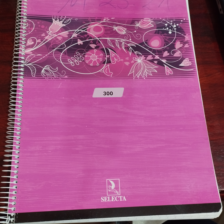

Class prediction: strainer


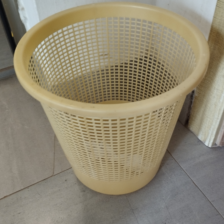

Class prediction: orange


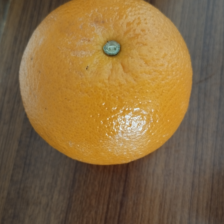

Class prediction: coffee mug


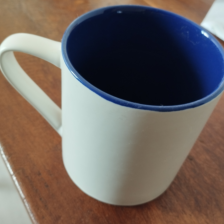

Class prediction: notebook, notebook computer


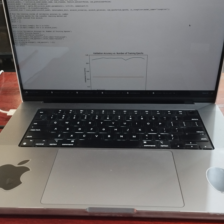

Class prediction: paper towel


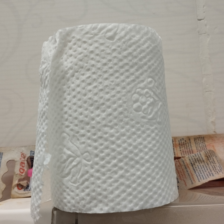

Class prediction: binder, ring-binder


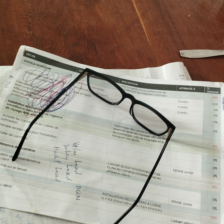

In [66]:
folder = 'images'
# load list of ImageNet classes:
url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
with urllib.request.urlopen(url) as f:
    classes = f.read().decode("utf-8")
    classes = re.sub("(\d+)(:)", "\"\g<1>\":", classes)
    classes = re.sub("(')([A-Za-z, '\-.]+)(')", "\"\g<2>\"", classes)
    classes = json.loads(classes)
    classes = {int(key): value for key, value in classes.items()}
    
for i in range(len(os.listdir(folder))):
    
    # get list of all files in your folder:
    IMG_PATH = folder + '/' + os.listdir(folder)[i]#"laptop.jpg" # TODO : uplaod some image in colab and insert the image path

    # load pre-trained model (we need to re-load because we changed the model we loaded earlier):
    imagenet_resnet = torchvision.models.resnet18(pretrained=True)
    if device == "cuda":
        imagenet_resnet = imagenet_resnet.cuda()
    imagenet_resnet.eval()

    pil_image = PIL.Image.open(IMG_PATH)

        # normalize image and take center crop:
    pil_image = transforms.CenterCrop(224)(transforms.Resize(256)(pil_image))
    image = transforms.ToTensor()(pil_image)
    if image.size(0) == 4:  # remove alpha-channel if present
        image = image[:-1,:]       
    image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)

    # make class prediction:
    if device == "cuda":
        image = image.cuda()
    prediction = imagenet_resnet(image.unsqueeze(0)).squeeze(0).cpu().argmax()

    # show result:
    print("Class prediction: %s" % classes[prediction.item()])
    display.display(pil_image) 


What do you observe? Are there visual classes for which the model works less well than you had expected? Can you figure out why and when the model breaks?

### Observations

I observe that for some images, the model is able to recognize the true class. 

One of the reasons why the model it is not able to work well everywhere can be because of the background of the image or the position from which the image was taken, since the dataset used to train the model was not containing such images, the model struggle to recognize them well.